In [1]:
import os
import random
from random import randint
import numpy as np
import pandas as pd
import pickle 

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn import metrics
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
from dynamicTreeCut import cutreeHybrid
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram

from gensim.models import Word2Vec
import networkx as nx

import matplotlib.pyplot as plt
import plotly.express as px

# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

SEED = 42
os.environ["PYTHONHASHSEED"] = str(SEED)
# seed the global RNG 
random.seed(SEED)
# seed the global NumPy RNG
np.random.seed(SEED)

#### K-means and Hierarchical clustering of node embeddings

Plot Hierarchical Clustering Dendrogram:
 
 > https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [2]:
def plot_dendrogram(model, **kwargs):
    """
    this function plots the corresponding dendrogram of a hierarchical clustering 
    :param model: hierarchical clustering model 
    """
    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    # create linkage matrix and then plot the dendrogram
    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [3]:
def find_clusters(df, filename, graph=None, seed=SEED):
    """
    this function computes cluster labels for the input samples 
    :param df: dataframe of (n_samples, n_features) with samples as index 
    :param filename: name of output file
    :param g: graph for visualization of detected communities 
    :param seed: seed for reproducibility 
    :return: dataframe with samples and corresponding clusters
    """
    # seed the global RNG 
    random.seed(seed)
    np.random.seed(seed)

    # get values
    X = df.values

    ## K-MEANS CLUSTERING
    # initialize the clustering model with n_clusters value and a random generator seed
    range_n_clusters = [10, 20, 30, 40, 50]
    silhouette_scores = []
    for n_clusters in range_n_clusters:
        K_model = KMeans(n_clusters=n_clusters, random_state=seed)
        cluster_labels = K_model.fit_predict(X)
        
        # compute silhouette score [1,-1]
        silhouette_avg = silhouette_score(X, cluster_labels)
        silhouette_scores.append((n_clusters, silhouette_avg)) 
        print("For n_clusters =",
            n_clusters,
            "The average silhouette_score is :",
            silhouette_avg)

    # number of clusters corresponding to maximum silhouette score
    K_clusters = max(silhouette_scores, key=lambda item:item[1])[0]
    K_model = KMeans(n_clusters=K_clusters,  random_state=seed).fit(X)
    print(K_model)
    # store samples and clusters in a dictionary
    cl_dct = dict(zip(df.index, K_model.labels_))

    if graph:
        # generate random colors for plotting
        color = []
        for i in range(K_clusters):
            color.append('#%06X' % randint(0, 0xFFFFFF))
        # construct color map
        cmap = dict((color.index(col),col) for col in color)

        # plot clusters/communities
        node_cmap = [cmap[v] for _,v in cl_dct.items()]
        # k optimal distance between nodes
        pos = nx.spring_layout(graph, k=0.05, seed = SEED)
        plt.figure(figsize=(3,3)) 
        nx.draw(graph, pos, node_size = 10, alpha = 0.8, node_color = node_cmap)
        plt.show()

    ## HIERARCHICAL CLUSTERING
    # determine the number of clusters by dynamic tree cut
    distances = pdist(X, "cosine")
    link = linkage(distances, "average")
    H_clusters = cutreeHybrid(link, distances)
    n_H_clusters = len(np.unique(H_clusters["labels"]))

    # agglomerative clustering performs hierarchical clustering using a bottom up approach 
    H_model = AgglomerativeClustering(n_clusters=n_H_clusters, affinity = 'cosine', linkage='average', 
                                compute_distances=True).fit(X)
    print(H_model)

    # plot dendogram
    plt.figure(figsize=(11,5))
    plt.rcParams.update({'font.size': 14})
    plt.title("Hierarchical Clustering Dendrogram")
    # plot the top levels of the dendrogram
    plot_dendrogram(H_model, truncate_mode="level", p=5)
    ax = plt.gca()
    ax.tick_params(axis='x', which='major', labelsize=12)
    ax.tick_params(axis='y', which='major', labelsize=12)
    plt.xlabel("Number of points in node (or index of point if no parenthesis).")
    plt.show()
    
    # save clusters
    cl_df = pd.DataFrame({'CID' : cl_dct.keys(), 'kmeans_cluster' : cl_dct.values(), 
                    'hierarchical_cluster' : H_model.labels_})
    cl_df.to_csv(filename, index=False, header=True)

    return cl_df

In [4]:
# define models path name
path = "../Embedding_models/"
models = ['FPBitsEmbedding',
        'FPCountsEmbedding',
        'MolDescEmbedding',
        'QuantumPropsEmbedding']
pnames = [path + p for p in models]

In [5]:
# define path to save
path_save = "../Flask/pollutants_db_app/static/img"

##### FP bits space

In [6]:
# read FPB object
filename = '../Preprocessed_data/fp_bits.obj'
filehandler = open(filename, 'rb') 
Fpb_obj = pickle.load(filehandler)
Fpb_obj

{'annotation': {'samples': Int64Index([   8680,  143127,   10870,   69848,   12993,  164514,   86240,
                13129,   67884,    6278,
              ...
                 1117,    1119,   24682, 4685067,   14778,   24841,   14781,
                11430,   26042,   24193],
             dtype='int64', length=1750),
  'features': Index(['FP1', 'FP2', 'FP3', 'FP4', 'FP5', 'FP6', 'FP7', 'FP8', 'FP9', 'FP10',
         ...
         'AD2D714', 'AD2D715', 'AD2D726', 'AD2D729', 'AD2D735', 'AD2D760',
         'AD2D765', 'AD2D766', 'AD2D770', 'AD2D780'],
        dtype='object', length=5218)},
 'tfidf': {'tfidf_transformer': TfidfTransformer(),
  'tfidf_data': <1750x5218 sparse matrix of type '<class 'numpy.float64'>'
  	with 467820 stored elements in Compressed Sparse Row format>},
 'lsa': {'lsa_data': array([[ 4.46150378e-01,  4.65599796e-01, -2.30471042e-01, ...,
           1.78108040e-02, -4.14571861e-03,  3.34084720e-02],
         [ 7.61418679e-01, -2.97931919e-01, -2.92913529e-01, ...,

In [7]:
# get model embeddings
model = Word2Vec.load(pnames[0])
fpb_emb = (pd.DataFrame([model.wv.get_vector(str(n)) for n in Fpb_obj['net']['graph'].nodes],
                            index = Fpb_obj['net']['graph'].nodes()))
fpb_emb

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
8680,-0.866967,0.296615,-0.222460,0.472802,0.016910,0.677371,-0.908341,0.605429,0.078423,-0.094592,...,-0.165323,0.126334,-0.320908,-0.737836,-0.823524,0.403877,0.272555,-0.648903,0.083383,-0.320778
10870,-0.799258,0.346314,-0.224523,0.472229,0.004401,0.616721,-1.014208,0.741633,0.127541,-0.079888,...,-0.218567,0.083845,-0.325222,-0.715212,-0.857278,0.382533,0.326637,-0.491693,0.142238,-0.261202
8404,-1.028862,0.147790,-0.459851,0.662856,0.171555,0.298662,-1.057714,0.583047,-0.011810,-0.016896,...,-0.059095,-0.127231,-0.098785,-0.645144,-0.860507,0.406305,0.399557,-0.569224,0.537296,-0.314600
187815,-0.670729,0.231425,-0.342096,0.847995,0.166504,0.470785,-1.031842,0.601430,0.023011,0.107114,...,-0.246948,0.035930,-0.173499,-0.576905,-0.959373,0.505139,-0.032177,-0.316096,0.303331,-0.221896
520522,-0.509826,0.274024,-0.236256,0.864152,0.137325,0.379273,-1.083867,0.663994,-0.087543,0.154420,...,-0.346417,0.052691,-0.182156,-0.457053,-1.041742,0.392904,-0.039882,-0.341843,0.147607,-0.367056
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24823,-1.226677,-0.239125,-0.824500,0.212294,-0.507747,-0.874776,-0.442390,1.211045,-1.900563,1.136223,...,-1.445691,-0.579620,-0.256784,0.605110,-0.898083,0.530797,-0.361648,0.188997,-0.275230,-0.184174
25477,-1.028709,-0.317146,-1.032748,0.491444,-0.867374,-1.066523,-0.408647,1.183118,-1.568711,1.096029,...,-1.212594,-0.808755,-0.259999,0.614169,-1.074466,0.773279,-0.615277,0.068666,-0.325014,-0.108630
14792,-1.219163,-0.389239,-1.227988,0.309104,-0.728013,-0.980858,-0.486919,1.143384,-1.582393,1.181507,...,-1.428807,-0.710210,-0.484979,0.636625,-1.072320,0.653015,-0.330813,0.051915,-0.364914,-0.184657
14778,-1.258614,-0.373661,-1.227514,0.340207,-0.678003,-1.064465,-0.495927,1.049748,-1.608316,1.141676,...,-1.484685,-0.722804,-0.448743,0.632031,-0.941732,0.711065,-0.430843,0.051962,-0.404178,-0.332076


For n_clusters = 10 The average silhouette_score is : 0.31160134
For n_clusters = 20 The average silhouette_score is : 0.34413967
For n_clusters = 30 The average silhouette_score is : 0.3578913
For n_clusters = 40 The average silhouette_score is : 0.3237498
For n_clusters = 50 The average silhouette_score is : 0.32377654
KMeans(n_clusters=30, random_state=42)


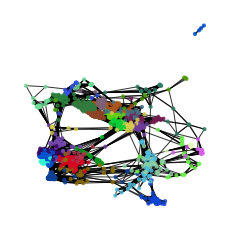

..cutHeight not given, setting it to 0.744314526640827  ===>  99% of the (truncated) height range in dendro.
..done.
AgglomerativeClustering(affinity='cosine', compute_distances=True,
                        linkage='average', n_clusters=25)


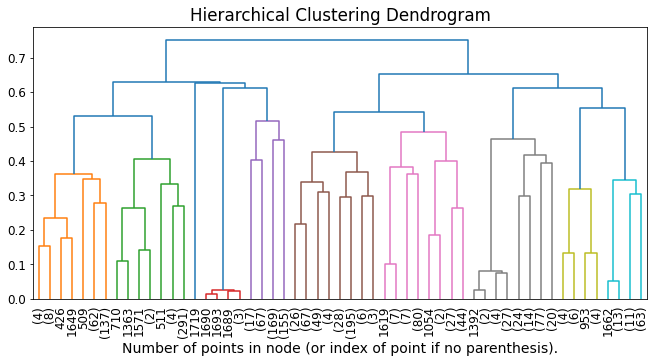

,CID,kmeans_cluster,hierarchical_cluster
0,8680,0,21
1,10870,0,21
2,8404,0,21
3,187815,0,21
4,520522,0,21
...,...,...,...
1744,24823,29,14
1745,25477,29,14
1746,14792,29,14
1747,14778,29,14


In [8]:
# compute clustering
fpb_cluster_emb  = find_clusters(fpb_emb, '../Clustering_results/FPBits_Clustering_embedding.csv', Fpb_obj['net']['graph'])
fpb_cluster_emb

##### Visualize node embeddings with TSNE

In [9]:
# apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=3, metric='cosine', random_state=0)
projections = pd.DataFrame(tsne.fit_transform(fpb_emb))
projections.columns = ['dim1', 'dim2', 'dim3']
projections.head(5)

,dim1,dim2,dim3
0,4.862834,8.918362,-11.975737
1,4.862629,8.945499,-11.766169
2,7.196714,8.970057,-11.142379
3,3.944873,11.489580,-9.847887
4,3.913934,11.706253,-9.382376


In [10]:
# 3D plot of K-means clustering 
hover_name = [('CID: '+str(x)) for x in fpb_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=fpb_cluster_emb['kmeans_cluster'].astype(int), labels={'color': 'K-means cluster'},
    hover_name=hover_name,
    width=820, height=670,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    color_discrete_sequence=px.colors.sequential.Plasma_r
    )

# layout    
fig.update_traces(marker_size=4, opacity=0.8)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    yaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    zaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title='')
                    ), margin=dict(l=0, r=0, t=0, b=70))
fig.update(layout_coloraxis_showscale=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}

# save and show 
fig.write_html(path_save + "/fingerprints_bits_kmeans.html", config=config)
fig.update_layout(width=350, height=350, margin=dict(l=0, r=0, t=0, b=0))
fig.show(config=config)

In [17]:
# create a separate legend with number of molecules in each cluster
fpb_legend = pd.DataFrame(fpb_cluster_emb.groupby(['kmeans_cluster'])['CID'].count()).reset_index()
fpb_legend.rename(columns={"CID": "#Molecules"}, inplace=True)
fpb_legend['value'] = 0

# scatter plot
fig = px.scatter(fpb_legend, x="kmeans_cluster", y="value", color=fpb_legend['kmeans_cluster'].astype(int),
                 size="#Molecules", hover_data={"#Molecules": True, 'value': False, 'kmeans_cluster' : False}, 
                 labels={'color': 'cluster'},
                 title="K-means clusters",
                 height=210, width=920,
                 color_discrete_sequence=px.colors.sequential.Plasma_r,)

# remove axes ticks and background
fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", 
                xaxis = dict(tickvals=fpb_legend["kmeans_cluster"], title=''),
                yaxis = dict(showticklabels=False, title=''),
                margin=dict(l=40, r=40),)
fig.update(layout_coloraxis_showscale=False)

# configuration
config = {'displayModeBar': False, 'displaylogo': False}
# save and show
fig.write_html(path_save + "/fingerprints_bits_legend.html", config=config)
fig.show(config=config)

In [120]:
# 3D plot of hierarchical clustering 
hover_name = [('CID: '+str(x)) for x in fpb_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=fpb_cluster_emb['hierarchical_cluster'].astype(str), labels={'color': 'Hierarchical cluster'},
    hover_name=hover_name,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    range_color=[fpb_cluster_emb['hierarchical_cluster'].min(), fpb_cluster_emb['hierarchical_cluster'].max()], 
    color_discrete_sequence=px.colors.sequential.Viridis_r
    )

# layout
fig.update_traces(marker_size=3, opacity=0.7)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, title=''),
                    yaxis = dict(showticklabels=False, title=''),
                    zaxis = dict(showticklabels=False, title='')
                    ), margin=dict(l=0, r=0, t=0, b=0))
fig.update(layout_showlegend=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}

# show
fig.update_layout(width=300, height=300)
fig.show(config=config)

##### FP counts space

In [11]:
# read FP object
filename = '../Preprocessed_data/fp_counts.obj'
filehandler = open(filename, 'rb') 
Fpc_obj = pickle.load(filehandler)
Fpc_obj

{'annotation': {'samples': Int64Index([   8680,  143127,   10870,   69848,   12993,  164514,   86240,
                13129,   67884,    6278,
              ...
                 1117,    1119,   24682, 4685067,   14778,   24841,   14781,
                11430,   26042,   24193],
             dtype='int64', length=1750),
  'features': Index(['SubFPC1', 'SubFPC2', 'SubFPC3', 'SubFPC4', 'SubFPC5', 'SubFPC6',
         'SubFPC7', 'SubFPC8', 'SubFPC9', 'SubFPC10',
         ...
         'APC2D10_C_X', 'APC2D10_N_N', 'APC2D10_O_O', 'APC2D10_O_F',
         'APC2D10_O_X', 'APC2D10_Cl_Cl', 'APC2D10_Cl_X', 'APC2D10_Br_Br',
         'APC2D10_Br_X', 'APC2D10_X_X'],
        dtype='object', length=1515)},
 'tfidf': {'tfidf_transformer': TfidfTransformer(),
  'tfidf_data': <1750x1515 sparse matrix of type '<class 'numpy.float64'>'
  	with 76585 stored elements in Compressed Sparse Row format>},
 'lsa': {'lsa_data': array([[ 8.12594735e-01,  3.60701844e-01, -1.29693415e-02, ...,
          -9.78689333e-0

In [12]:
# get model embeddings
model = Word2Vec.load(pnames[1])
fpc_emb = (pd.DataFrame([model.wv.get_vector(str(n)) for n in Fpc_obj['net']['graph'].nodes],
                            index = Fpc_obj['net']['graph'].nodes()))
fpc_emb

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
8680,-0.402176,0.088793,0.239448,0.041354,0.437491,-0.280641,-0.514939,0.332917,-0.083597,-0.241567,...,0.173321,0.346681,0.155529,0.133563,0.025690,-0.184898,0.087529,-0.529317,0.054986,-0.089763
10870,-0.287763,0.186413,0.233496,-0.080812,0.488311,-0.366777,-0.482682,0.297932,-0.054893,-0.206802,...,0.227979,0.271664,0.079061,0.121250,0.120795,-0.040346,0.137126,-0.555276,0.090876,-0.118207
69848,-0.263194,0.094540,0.256251,-0.196617,0.481221,-0.051689,-0.400757,0.366116,-0.004975,-0.240793,...,0.038983,0.073786,0.204786,0.041430,0.087561,-0.027100,-0.340133,-0.583263,0.003557,-0.056694
8404,-0.307051,0.157034,0.273995,-0.059340,0.574080,-0.220637,-0.486692,0.285917,0.160518,-0.187521,...,0.022925,0.214504,0.068761,0.249624,0.096760,-0.210009,-0.016110,-0.504199,0.070098,-0.031487
10263,0.080854,-0.076255,0.296634,0.001935,0.504910,-0.263212,-0.719029,0.367368,0.121475,-0.141924,...,0.005261,0.039489,0.296612,-0.099161,-0.059565,-0.138884,0.120785,-0.306526,0.004356,-0.019592
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25477,-0.136084,-0.341661,-0.774612,-0.169315,1.067489,-1.025165,-0.296313,-0.216427,0.293236,-0.976334,...,-0.514553,0.186602,0.269435,0.792491,0.963774,-0.054417,0.764971,0.981089,-0.205339,0.645119
14781,-0.335852,-0.292504,-0.713335,-0.138853,1.088612,-1.125854,-0.250568,-0.199146,0.316453,-1.047751,...,-0.407510,0.018327,0.364036,0.870076,0.862538,-0.089640,0.819786,1.142953,-0.060196,0.661827
14792,0.322049,-0.422676,-0.807308,0.151066,0.167747,-1.123253,-0.318020,0.508886,0.212087,-0.193458,...,-0.100824,0.579917,-0.299258,0.554736,-0.086615,0.187526,0.941637,0.534199,-0.149491,0.727420
14778,0.237458,-0.341913,-0.815454,0.150429,0.290590,-1.073505,-0.194143,0.365034,0.141754,-0.071355,...,-0.181228,0.626130,-0.364827,0.502480,-0.112548,0.134094,0.874972,0.662928,-0.087517,0.852770


For n_clusters = 10 The average silhouette_score is : 0.210787
For n_clusters = 20 The average silhouette_score is : 0.19565457
For n_clusters = 30 The average silhouette_score is : 0.21178715
For n_clusters = 40 The average silhouette_score is : 0.21070093
For n_clusters = 50 The average silhouette_score is : 0.18693268
KMeans(n_clusters=30, random_state=42)


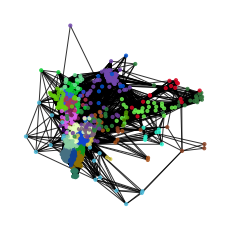

..cutHeight not given, setting it to 0.8673268406917425  ===>  99% of the (truncated) height range in dendro.
..done.
AgglomerativeClustering(affinity='cosine', compute_distances=True,
                        linkage='average', n_clusters=19)


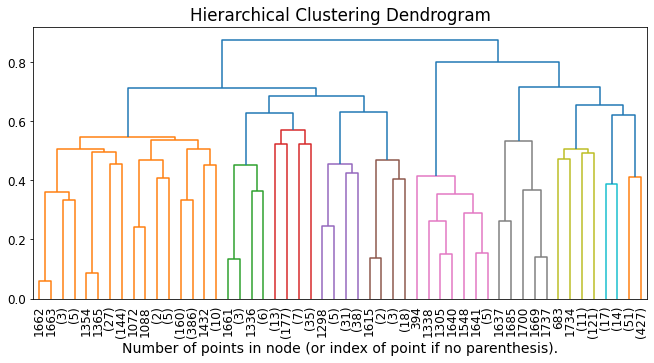

,CID,kmeans_cluster,hierarchical_cluster
0,8680,13,4
1,10870,13,4
2,69848,13,4
3,8404,13,4
4,10263,13,4
...,...,...,...
1745,25477,8,1
1746,14781,8,1
1747,14792,24,1
1748,14778,24,1


In [13]:
# compute clustering
fpc_cluster_emb = find_clusters(fpc_emb, '../Clustering_results/FPCounts_Clustering_embedding.csv', Fpc_obj['net']['graph'])
fpc_cluster_emb

##### Visualize node embeddings with TSNE

In [14]:
# apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=3, metric='cosine', random_state=0)
projections = pd.DataFrame(tsne.fit_transform(fpc_emb))
projections.columns = ['dim1', 'dim2', 'dim3']
projections.head(5)

,dim1,dim2,dim3
0,-8.911235,16.701784,1.862998
1,-8.928343,16.529512,2.231875
2,-7.386255,12.850854,-0.489489
3,-8.983811,15.470805,0.325706
4,-12.840949,15.917643,1.642891


In [16]:
# 3D plot of K-means clustering 
hover_name = [('CID: '+str(x)) for x in fpc_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=fpc_cluster_emb['kmeans_cluster'].astype(int), labels={'color': 'K-means cluster'},
    hover_name=hover_name,
    width=820, height=670,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    color_discrete_sequence=px.colors.sequential.Plasma_r
    )
    
# layout    
fig.update_traces(marker_size=4, opacity=0.8)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    yaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    zaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title='')
                    ), margin=dict(l=0, r=0, t=0, b=100))
fig.update(layout_coloraxis_showscale=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}

# save and show
fig.write_html(path_save + "/fingerprints_counts_kmeans.html", config=config)
fig.update_layout(width=380, height=320, margin=dict(l=0, r=0, t=0, b=0))
fig.show(config=config)

In [44]:
# create a separate legend with number of molecules in each cluster
fpc_legend = pd.DataFrame(fpc_cluster_emb.groupby(['kmeans_cluster'])['CID'].count()).reset_index()
fpc_legend.rename(columns={"CID": "#Molecules"}, inplace=True)
fpc_legend['value'] = 0

# scatter plot
fig = px.scatter(fpc_legend, x="kmeans_cluster", y="value", color=fpc_legend['kmeans_cluster'].astype(int),
                 size="#Molecules", hover_data={"#Molecules": True, 'value': False, 'kmeans_cluster' : False}, 
                 labels={'color': 'cluster'},
                 title="K-means clusters",
                 height=210, width=920,
                 color_discrete_sequence=px.colors.sequential.Plasma_r,)

# remove axes ticks and background
fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", 
                xaxis = dict(tickvals=fpc_legend["kmeans_cluster"], title=''),
                yaxis = dict(showticklabels=False, title=''),
                margin=dict(l=40, r=40))
fig.update(layout_coloraxis_showscale=False)

# configuration
config = {'displayModeBar': False, 'displaylogo': False}
# save and show
fig.write_html(path_save + "/fingerprints_counts_legend.html", config=config)
fig.show(config=config)

In [141]:
# 3D plot of hierarchical clustering 
hover_name = [('CID: '+str(x)) for x in fpc_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=fpc_cluster_emb['hierarchical_cluster'].astype(str), labels={'color': 'Hierarchical cluster'},
    hover_name=hover_name,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    range_color=[fpc_cluster_emb['hierarchical_cluster'].min(), fpc_cluster_emb['hierarchical_cluster'].max()], 
    color_discrete_sequence=px.colors.sequential.Viridis_r
    )

# layout
fig.update_traces(marker_size=3, opacity=0.7)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, title=''),
                    yaxis = dict(showticklabels=False, title=''),
                    zaxis = dict(showticklabels=False, title='')
                    ), margin=dict(l=0, r=0, t=0, b=0))
fig.update(layout_showlegend=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}

# save and show 
fig.update_layout(width=400, height=320)
fig.show(config=config)


##### Molecular descriptors space

In [45]:
# read MD object
filename = '../Preprocessed_data/mol_desc.obj'
filehandler = open(filename, 'rb') 
Md_obj = pickle.load(filehandler)
Md_obj

{'annotation': {'samples': Int64Index([   8680,  143127,   10870,   69848,   12993,  164514,   86240,
                13129,   67884,    6278,
              ...
                 1117,    1119,   24682, 4685067,   14778,   24841,   14781,
                11430,   26042,   24193],
             dtype='int64', length=1750),
  'features': Index(['nAcid', 'ALogP', 'ALogp2', 'AMR', 'apol', 'naAromAtom', 'nAromBond',
         'nAtom', 'nHeavyAtom', 'nH',
         ...
         'P1s', 'P2s', 'E1s', 'E2s', 'E3s', 'Ts', 'As', 'Vs', 'Ks', 'Ds'],
        dtype='object', length=1675)},
 'pca': {'pca_data': array([[ -7.05043105,   4.41111069,  -8.69597704, ...,   1.06360682,
            1.51658494,   0.22010407],
         [  0.58941326,  -2.41669609, -11.55908192, ...,  -0.17072875,
           -0.07989102,  -0.16213433],
         [ -6.67228085,   3.56642181,  -8.64308698, ...,   0.13109836,
            1.18292608,   0.89302626],
         ...,
         [ -9.13388871,  -6.88906247,  15.71301314, ...,   

In [46]:
# get model embeddings
model = Word2Vec.load(pnames[2])
md_emb = (pd.DataFrame([model.wv.get_vector(str(n)) for n in Md_obj['net']['graph'].nodes],
                            index = Md_obj['net']['graph'].nodes()))
md_emb

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
8680,-0.246177,0.157681,0.181785,-0.040293,0.182049,0.741017,-0.472964,-0.117177,-0.252520,-0.194260,...,-0.344896,-0.242511,-0.047614,-0.392978,-0.022980,-0.138549,-0.065077,-0.637553,-0.234809,0.426497
10870,-0.315737,0.350800,-0.153530,-0.433602,-0.085721,0.794984,-0.348799,-0.049916,-0.446042,-0.165950,...,-0.302814,-0.216280,-0.062338,-0.212022,-0.180898,-0.020532,0.115047,-0.659033,-0.212127,0.296001
69848,0.006062,0.066742,0.008419,-0.141850,-0.097089,0.837361,-0.604088,-0.282330,-0.278898,-0.155420,...,-0.081351,-0.408337,-0.203835,-0.091245,-0.273480,-0.084164,-0.066957,-0.420053,-0.294501,0.353676
8404,0.023125,0.115349,0.238206,0.076338,0.238293,0.796872,-0.548679,-0.185385,0.116126,0.144698,...,-0.112772,-0.575563,-0.236598,-0.249229,-0.280954,-0.080848,-0.171624,-0.520018,-0.570365,0.566151
10263,0.040109,0.175159,0.036587,0.217885,0.252395,0.871842,-0.444651,-0.051542,0.375998,-0.131516,...,-0.135755,-0.272730,-0.301493,-0.016875,0.149588,-0.302810,0.232252,-0.582499,-0.183038,0.402119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26042,0.966407,-0.468175,-0.044047,0.651988,0.368555,1.723806,0.862850,-0.589936,-0.148162,-0.327886,...,-0.138351,-0.898435,1.065100,0.162862,-0.269278,0.467872,0.712172,1.171901,0.623556,0.794364
6347,-0.048873,0.998589,-1.382895,1.679628,-1.404964,2.230458,-0.068147,0.511905,1.649138,1.441238,...,-1.513163,-0.649496,-0.442710,-0.449785,0.147685,0.973504,0.203858,-0.807601,0.347698,0.493994
145068,-0.087644,1.003903,-1.367210,1.675245,-1.360914,2.249336,-0.070584,0.556419,1.613709,1.411691,...,-1.467644,-0.664829,-0.431031,-0.472024,0.150377,0.963223,0.245186,-0.811746,0.398104,0.443080
11430,0.427014,-1.025009,-0.708491,0.484980,0.327618,1.364695,0.867411,0.314556,0.412004,-0.752104,...,-1.040348,-0.273694,2.203754,-0.435340,-0.505016,1.014951,0.809679,1.465913,1.121559,-0.264163


For n_clusters = 10 The average silhouette_score is : 0.21754058
For n_clusters = 20 The average silhouette_score is : 0.24381942
For n_clusters = 30 The average silhouette_score is : 0.2480801
For n_clusters = 40 The average silhouette_score is : 0.24775812
For n_clusters = 50 The average silhouette_score is : 0.2138901
KMeans(n_clusters=30, random_state=42)


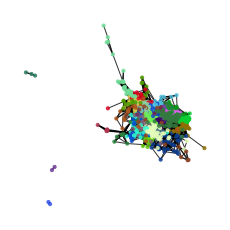

..cutHeight not given, setting it to 0.7795868017339794  ===>  99% of the (truncated) height range in dendro.
..done.
AgglomerativeClustering(affinity='cosine', compute_distances=True,
                        linkage='average', n_clusters=29)


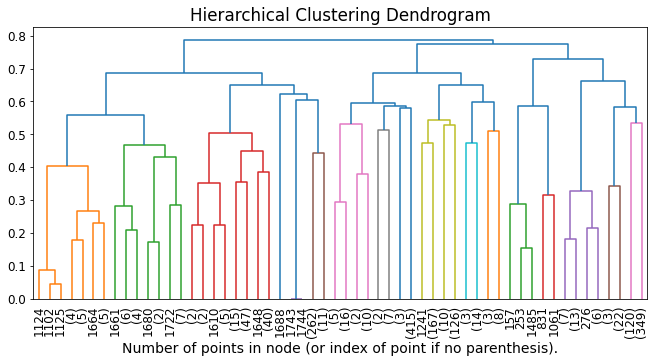

,CID,kmeans_cluster,hierarchical_cluster
0,8680,0,0
1,10870,0,0
2,69848,0,23
3,8404,12,0
4,10263,12,0
...,...,...,...
1742,26042,17,5
1743,6347,28,21
1744,145068,28,21
1745,11430,17,5


In [47]:
# compute clustering
md_cluster_emb = find_clusters(md_emb, '../Clustering_results/MolecularDesc_Clustering_embedding.csv', Md_obj['net']['graph'])
md_cluster_emb

##### Visualize node embeddings with TSNE

In [48]:
# apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=3, metric='cosine', random_state=0)
projections = pd.DataFrame(tsne.fit_transform(md_emb))
projections.columns = ['dim1', 'dim2', 'dim3']
projections.head(5)

,dim1,dim2,dim3
0,-4.311866,-8.806159,3.208127
1,-4.490402,-8.672802,2.124923
2,-5.032636,-8.079082,2.444952
3,1.208118,-6.731315,6.522436
4,0.950184,-8.636862,5.414858


In [49]:
# 3D plot of K-means clustering 
hover_name = [('CID: '+str(x)) for x in md_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=md_cluster_emb['kmeans_cluster'].astype(str), labels={'color': 'K-means cluster'},
    hover_name=hover_name,
    width=820, height=670,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    range_color=[md_cluster_emb['kmeans_cluster'].min(), md_cluster_emb['kmeans_cluster'].max()], 
    color_discrete_sequence=px.colors.sequential.Plasma_r
    )

# layout
fig.update_traces(marker_size=4, opacity=0.8)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    yaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    zaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title='')
                    ), margin=dict(l=0, r=0, t=0, b=50))
fig.update(layout_showlegend=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}

# save and show
fig.write_html(path_save + "/molecular_desc_kmeans.html", config=config)
fig.update_layout(width=300, height=300, margin=dict(l=0, r=0, t=0, b=0))
fig.show(config=config)

In [50]:
# create a separate legend with number of molecules in each cluster
md_legend = pd.DataFrame(md_cluster_emb.groupby(['kmeans_cluster'])['CID'].count()).reset_index()
md_legend.rename(columns={"CID": "#Molecules"}, inplace=True)
md_legend['value'] = 0

# scatter plot
fig = px.scatter(md_legend, x="kmeans_cluster", y="value", color=md_legend['kmeans_cluster'].astype(int),
                 size="#Molecules", hover_data={"#Molecules": True, 'value': False, 'kmeans_cluster' : False}, 
                 labels={'color': 'cluster'},
                 title="K-means clusters",
                 height=210, width=1000,
                 color_discrete_sequence=px.colors.sequential.Plasma_r,)

# remove axes ticks and background
fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", 
                xaxis = dict(tickvals=md_legend["kmeans_cluster"], title=''),
                yaxis = dict(showticklabels=False, title=''),
                margin=dict(l=40, r=40))
fig.update(layout_coloraxis_showscale=False)

# configuration
config = {'displayModeBar': False, 'displaylogo': False}
# save and show
fig.write_html(path_save + "/molecular_desc_legend.html", config=config)
fig.show(config=config)

In [172]:
# 3D plot of hierarchical clustering 
hover_name = [('CID: '+str(x)) for x in md_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=md_cluster_emb['hierarchical_cluster'].astype(str), labels={'color': 'Hierarchical cluster'},
    hover_name=hover_name,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    range_color=[md_cluster_emb['hierarchical_cluster'].min(), md_cluster_emb['hierarchical_cluster'].max()], 
    color_discrete_sequence=px.colors.sequential.Viridis_r
    )

# layout
fig.update_traces(marker_size=3, opacity=0.7)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, title=''),
                    yaxis = dict(showticklabels=False, title=''),
                    zaxis = dict(showticklabels=False, title='')
                    ), margin=dict(l=0, r=0, t=0, b=0))
fig.update(layout_showlegend=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}


# save and show 
fig.update_layout(width=300, height=300)
fig.show(config=config)

#####  Quantum properties space

In [51]:
# read QP object
filename = '../Preprocessed_data/quantum_props.obj'
filehandler = open(filename, 'rb') 
Qp_obj = pickle.load(filehandler)
Qp_obj

{'annotation': {'samples': Int64Index([ 528971,   13387,    7304,    7903,  181154,    8247,    5897,
                79123,    7245,  182210,
              ...
                24682, 4685067,   14781,   14778,   25477,   24841,    6328,
                11430,   26042,   24193],
             dtype='int64', name='Molecule_CID', length=1750),
  'features': Index(['Gas_Phase_Energy', 'Final_Energy', 'HOMO', 'LUMO', 'Polarizability',
         'QM_Dipole', 'QM_Dipole_X', 'QM_Dipole_Y', 'QM_Dipole_Z',
         'Lowest_Frequency', 'Highest_Frequency', 'Second_Lowest_Frequency',
         'Num_Negative_Frequencies', 'Zero_Point_Energy', 'Entropy', 'Enthalpy',
         'Free_Energy', 'Internal_Energy', 'Heat_Capacity', 'ln_Q',
         'Total_Internal_Energy', 'Total_Enthalpy', 'Total_Free_Energy'],
        dtype='object')},
 'pca': {'pca_data': array([[ 6.83221008, -2.03569661, -2.53132431, ..., -0.50173662,
           0.04728384,  0.28558018],
         [-2.44563902,  0.07856449,  0.18794303, .

In [52]:
# get model embeddings
model = Word2Vec.load(pnames[3])
qp_emb = (pd.DataFrame([model.wv.get_vector(str(n)) for n in Qp_obj['net']['graph'].nodes],
                            index = Qp_obj['net']['graph'].nodes()))
qp_emb

,0,1,2,3,4,5,6,7,8
528971,0.994912,0.817182,-0.687670,0.531547,1.243562,0.387009,1.443938,0.368526,-0.481915
181154,0.939768,0.692549,-0.717431,0.522955,1.308733,0.525808,1.414366,0.390314,-0.594548
94310,1.324515,1.024669,-0.774828,0.290076,1.234269,0.394411,1.213862,0.152783,-0.322526
176293,1.381362,1.099522,-0.414499,0.401547,1.255042,0.074914,1.353394,0.234940,-0.138391
12303119,1.000161,0.796365,-0.667653,0.450582,1.307667,0.264214,1.380408,0.269304,-0.463680
...,...,...,...,...,...,...,...,...,...
38307,-0.149346,0.202101,-2.257090,-1.271213,0.499304,-1.111615,1.612715,0.001937,1.157631
86240,-0.239278,0.652748,-2.736881,-1.579522,1.037539,-1.088457,1.421787,-0.305654,1.188783
1486,1.003858,1.089283,-1.702117,-1.302017,-1.475542,1.525695,2.281861,-0.530288,-1.495863
25477,-1.765228,1.520839,0.597712,-1.070112,0.738471,1.233591,0.779728,1.765611,-1.324410


For n_clusters = 10 The average silhouette_score is : 0.4133137
For n_clusters = 20 The average silhouette_score is : 0.46661204
For n_clusters = 30 The average silhouette_score is : 0.4334443
For n_clusters = 40 The average silhouette_score is : 0.37778214
For n_clusters = 50 The average silhouette_score is : 0.36630836
KMeans(n_clusters=20, random_state=42)


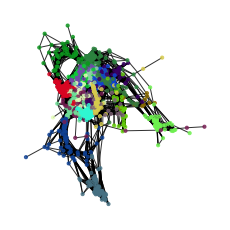

..cutHeight not given, setting it to 0.7323752163389969  ===>  99% of the (truncated) height range in dendro.
..done.
AgglomerativeClustering(affinity='cosine', compute_distances=True,
                        linkage='average', n_clusters=20)


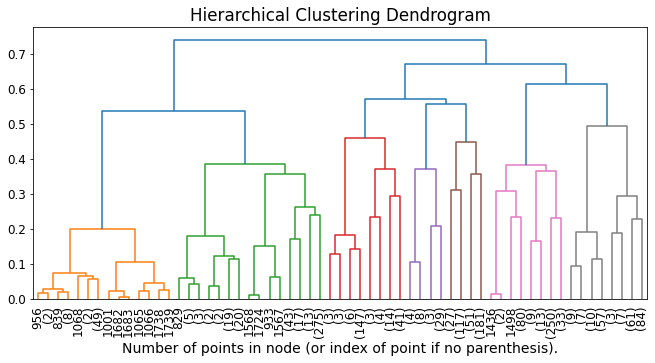

,CID,kmeans_cluster,hierarchical_cluster
0,528971,2,4
1,181154,2,4
2,94310,2,4
3,176293,2,4
4,12303119,2,4
...,...,...,...
1738,38307,7,13
1739,86240,12,13
1740,1486,10,1
1741,25477,13,0


In [53]:
# compute clustering
qp_cluster_emb = find_clusters(qp_emb, '../Clustering_results/QuantumProps_Clustering_embedding.csv', Qp_obj['net']['graph'])
qp_cluster_emb

##### Visualize node embeddings with TSNE

In [54]:
# apply t-SNE transformation on node embeddings
tsne = TSNE(n_components=3, metric='cosine', random_state=0)
projections = pd.DataFrame(tsne.fit_transform(qp_emb))
projections.columns = ['dim1', 'dim2', 'dim3']
projections.head(5)

,dim1,dim2,dim3
0,1.584573,-2.803082,-12.667551
1,4.376552,-0.900786,-12.539741
2,-0.100076,-6.709473,-14.888296
3,-1.235004,-6.573026,-11.821184
4,1.568214,-4.517052,-11.505312


In [55]:
# 3D plot of K-means clustering 
hover_name = [('CID: '+str(x)) for x in qp_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=qp_cluster_emb['kmeans_cluster'].astype(str), labels={'color': 'K-means cluster'},
    hover_name=hover_name,
    width=820, height=670,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    range_color=[qp_cluster_emb['kmeans_cluster'].min(), qp_cluster_emb['kmeans_cluster'].max()], 
    color_discrete_sequence=px.colors.sequential.Plasma_r
    )

# layout
fig.update_traces(marker_size=4, opacity=0.8)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    yaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title=''),
                    zaxis = dict(showticklabels=False, backgroundcolor="rgb(247,184,184)", title='')
                    ), margin=dict(l=0, r=0, t=0, b=0))
fig.update(layout_showlegend=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}

# save and show
fig.write_html(path_save + "/quantum_props_kmeans.html", config=config)
fig.update_layout(width=300, height=300, margin=dict(l=0, r=0, t=0, b=0))
fig.show(config=config)

In [56]:
# create a separate legend with number of molecules in each cluster
qp_legend = pd.DataFrame(qp_cluster_emb.groupby(['kmeans_cluster'])['CID'].count()).reset_index()
qp_legend.rename(columns={"CID": "#Molecules"}, inplace=True)
qp_legend['value'] = 0

# scatter plot
fig = px.scatter(qp_legend, x="kmeans_cluster", y="value", color=qp_legend['kmeans_cluster'].astype(int),
                 size="#Molecules", hover_data={"#Molecules": True, 'value': False, 'kmeans_cluster' : False}, 
                 labels={'color': 'cluster'},
                 title="K-means clusters",
                 height=210, width=920,
                 color_discrete_sequence=px.colors.sequential.Plasma_r,)

# remove axes ticks and background
fig.update_layout(plot_bgcolor="rgba(0,0,0,0)", 
                xaxis = dict(tickvals=qp_legend["kmeans_cluster"], title=''),
                yaxis = dict(showticklabels=False, title=''),
                margin=dict(l=40, r=40))
fig.update(layout_coloraxis_showscale=False)

# configuration
config = {'displayModeBar': False, 'displaylogo': False}
# save and show
fig.write_html(path_save + "/quantum_props_legend.html", config=config)
fig.show(config=config)

In [183]:
# 3D plot of hierarchical clustering 
hover_name = [('CID: '+str(x)) for x in qp_cluster_emb['CID'].values]
fig = px.scatter_3d(
    projections, x='dim1', y='dim2', z='dim3',
    color=qp_cluster_emb['hierarchical_cluster'].astype(str), labels={'color': 'Hierarchical cluster'},
    hover_name=hover_name,
    hover_data={'dim1': False, 'dim2': False, 'dim3': False},
    range_color=[qp_cluster_emb['hierarchical_cluster'].min(), qp_cluster_emb['hierarchical_cluster'].max()], 
    color_discrete_sequence=px.colors.sequential.Viridis_r
    )

# layout
fig.update_traces(marker_size=3, opacity=0.7)
fig.update_layout(scene = dict(
                    xaxis = dict(showticklabels=False, title=''),
                    yaxis = dict(showticklabels=False, title=''),
                    zaxis = dict(showticklabels=False, title='')
                    ), margin=dict(l=0, r=0, t=0, b=0))
fig.update(layout_showlegend=False)

# configuration
config = {'modeBarButtonsToRemove': ['logo', 'zoom3d', 'tableRotation', 
          'orbitRotation', 'pan3d', 'resetCameraLastSave3d'], 'displaylogo': False}

# save and show 
fig.update_layout(width=300, height=300)
fig.show(config=config)